# 10 Health Model

**Project:** NORI  
**Author:** Yuseof J  
**Date:** 23/12/25

### **Purpose**
Load all model features and health outcomes (model targets), model the data, then use SHAP to visualize the most influential features. 

### **Inputs**
- `data/processed/master_model_features.csv`
- `data/processed/master_model_targets.csv`

### **Outputs**
- ``
  
--------------------------------------------------------------------------

NOTE: This first pass is really just meant to get the ML and SHAP scaffolding set up. As of now, not enough model features are available to expect great model performance. 

### 0. Imports and Setup

In [1]:
# package imports
import os
import shap
import pandas as pd
import geopandas as gpd
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GroupKFold

# specify filepaths
path_nyc_tracts = 'data/processed/nyc_tracts.gpkg'
path_model_features = 'data/processed/master_features.csv'
path_model_targets = 'data/processed/outcomes_health.csv'

# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

### 1. Load Data

In [2]:
# nyc tracts
gdf_nyc_tracts = gpd.read_file(path_nyc_tracts, layer="tracts")

# features (X), targets (y)
X = pd.read_csv(path_model_features)
y = pd.read_csv(path_model_targets)

### 2. Prepare Data

For this first pass, we'll be focusing on just one target to get the pipeline up and running

In [3]:
TARGET = "DIABETES_CrudePrev"

y = y[['GEOID', TARGET]]

In [4]:
# take note of feature columns
feature_cols = X.columns.tolist()

# select only tracts with a value for the target
df_model = y.merge(X, how="left", on="GEOID")
df_model = df_model[df_model[TARGET].notna()]

# TODO: TEMPORARY: DROPPING NAN FEATURE ROWS UNTIL IMPUTATION METHOD DETERMINED
df_model = df_model.dropna(subset=feature_cols)

# reseperate features and target for modeling
X = df_model[feature_cols].copy()
y = df_model[TARGET].copy()

In [5]:
X.head()

,GEOID,distance_to_park_m,park_area_500m_centroid,park_area_1km_centroid,percent_tree_canopy,median_household_income,poverty_rate,unemployment_rate,gini_index,pct_higher_ed,pct_renters,median_gross_rent,pct_rent_burdened,pct_no_vehicle,pop_density_sq_km,pct_age_65_plus
0,36085024402,169.509962,1.206043e+05,6.859291e+05,0.031706,117981.0,0.029496,0.024523,0.4031,0.427270,0.181553,1429.0,0.324759,0.042032,2692.772684,0.193930
1,36085027705,2129.879397,0.000000e+00,0.000000e+00,0.000000,96684.0,0.099770,0.030645,0.4349,0.311325,0.182136,1799.0,0.698630,0.005988,11465.037656,0.191336
2,36085012806,0.000000,1.370448e+06,4.764153e+06,0.000000,61378.0,0.083870,0.037376,0.4349,0.259306,0.648697,1797.0,0.694598,0.004942,4022.827347,0.186134
3,36047024400,622.327717,0.000000e+00,3.497273e+05,0.000000,67500.0,0.398833,0.069648,0.3851,0.313904,0.621649,1748.0,0.601990,0.106186,23808.910470,0.078171
4,36047023000,972.144627,0.000000e+00,1.453035e+03,0.000000,51250.0,0.451197,0.177823,0.5221,0.188471,0.733522,1630.0,0.593068,0.104520,32376.888983,0.078985


In [6]:
y.head()

0     8.6
1    12.0
2    13.6
3    11.1
4    13.3
Name: DIABETES_CrudePrev, dtype: float64

#### Spatial CV - Borough

Here we'll bring in borough so that we can effectively split the data for spatial cross-validation. It's important to split the data by some meaningful geographic grouping because the tracts are not independent of one another: neighboring tracts share characteristics like socioeconomic conditions, health outcomes, air quality, and green coverage. If we split the spatial data at random, we may end up with the scenario where one tract is used for training, and its neighbor is used in testing. This will lead to overestimated model performance because those two tracts are too similar, meaning the model isn't learning to generalize to new places, but rather memorizing information about similar tract contexts/characteristics.

In [7]:
# ensure matching dtypes before join
X.GEOID = X.GEOID.astype(int)
gdf_nyc_tracts.GEOID = gdf_nyc_tracts.GEOID.astype(int)

# get borough names for tracts 
X = X.merge(gdf_nyc_tracts[['GEOID', 'BoroCode']], 
           how='left', 
           on='GEOID',
)

In [8]:
# create borough-based CV groups
groups = X['BoroCode']
cv = GroupKFold(n_splits=5)

In [9]:
# drop identifier and spatial label before modeling
X.drop(columns=['GEOID', 'BoroCode'], inplace=True)

#### Handling Missing Values

TODO: for now, nan rows are dropped (above) until a more comprehensive method is devloped

### 3. Baseline: Linear Regression

In [10]:
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

scores = cross_val_score(
    lr_pipe,
    X,
    y,
    cv=cv,
    groups=groups,
    scoring='r2'
)

print("Linear R2 (CV): ", scores.mean())

Linear R2 (CV):  0.6378371582213999


This r2 score makes sense given the lack of features, indicating the park and tree canopy features alone are not enough to meaningfully predict asthma prevalence

### 4. Enhanced Model: XGBoost

In [11]:
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

scores = cross_val_score(
    xgb,
    X,
    y,
    cv=cv,
    groups=groups,
    scoring='r2'
)

print("XGB R2 (CV): ", scores.mean())

XGB R2 (CV):  0.6035161443677056


### 5. SHAP - Feature Importance

In [12]:
# fit model to data to determine feature influence in model's predictions
xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

100%|===================| 2163/2168 [00:18<00:00]        

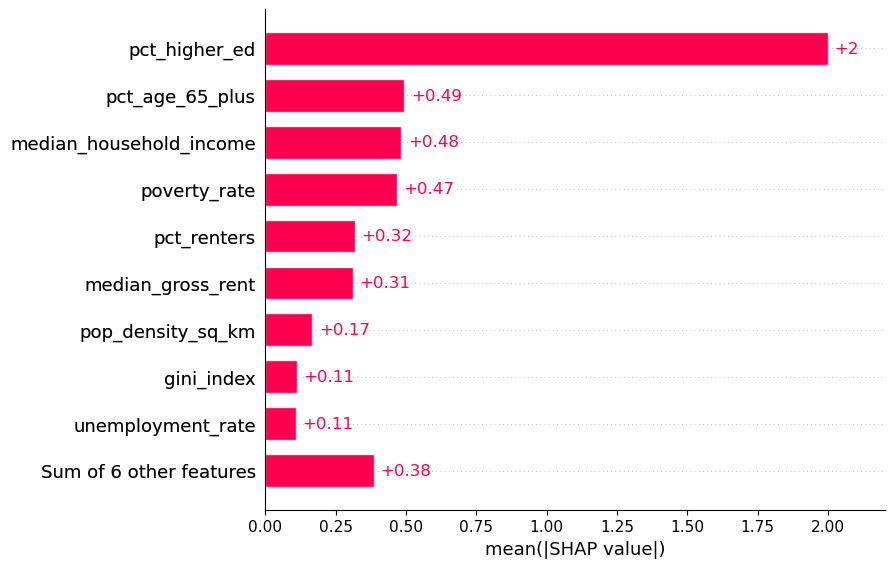

In [13]:
explainer = shap.Explainer(xgb, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)